In [60]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [61]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  \
0       2.207588            15            14                  6   
1      15.624266            15            14                  6   
2      12.203357            14            13                  6   
3       9.992448            14            13                  6   
4       7.780611            14            14                  6   

   bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  flow_pkts_per_sec  \
0                  6          6.794746          6.341763          13.136509   
1                  6          0.960045          0.896042           1.856087   
2                  5          1.147225          1.065281           2.212506   
3                  5          1.401058          1.300983           2.702041   
4                  5          1.799345          1.799345           3.598689   

   down_up_ratio  fwd_header_size_tot  fwd_header_size_min  \
0       0.933333                  464                   20   
1       0.933333                  488                   20   
2       0.928571                  432                   20   
3       0.928571                  432                   20   
4       1.000000                  432                   20   

   fwd_header_size_max  bwd_header_size_tot  bwd_header_size_min  \
0                   40                  492                   32   
1                   44                  468                   32   
2                   40                  448                   32   
3                   40                  436                   32   
4                   40                  480                   32   

   bwd_header_size_max  flow_FIN_flag_count  flow_SYN_flag_count  \
0                   44                    2                    2   
1                   44                    2                    2   
2                   44                    2                    2   
3                   44                    2                    2   
4                   44                    2                    2   

   flow_RST_flag_count  fwd_PSH_flag_count  bwd_PSH_flag_count  \
0                    2                   6                   5   
1                    2                   6                   5   
2                    2                   6                   5   
3                    2                   6                   5   
4                    2                   6                   5   

   flow_ACK_flag_count  fwd_URG_flag_count  bwd_URG_flag_count  \
0                   26                   0                   0   
1                   26                   0                   0   
2                   24                   0                   0   
3                   24                   0                   0   
4                   25                   0                   0   

   flow_CWR_flag_count  flow_ECE_flag_count  fwd_pkts_payload.min  \
0                    0                    0                     0   
1                    0                    0                     0   
2                    0                    0                     0   
3                    0                    0                     0   
4                    0                    0                     0   

   fwd_pkts_payload.max  fwd_pkts_payload.tot  fwd_pkts_payload.avg  \
0                   742                1826.0            121.733333   
1                   745                1829.0            121.933333   
2                   744                1828.0            130.571429   
3                   744                1828.0            130.571429   
4                   744                1828.0            130.571429   

   fwd_pkts_payload.std  bwd_pkts_payload.min  bwd_pkts_payload.max  \
0            220.736581                     0                  1448   
1            221.339257                     0                  1448   
2            226.803444                     0                  2896   
3            2

In [62]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [63]:
params = {
    'iterations': 80,
    'depth': 7,
    'learning_rate': 0.1,
    'loss_function': 'MultiClass',
    'verbose': True
}

cat = CatBoostClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [64]:
y_res.value_counts()

traffic_category
Background             7988
Benign                 7988
Bruteforce             7988
Bruteforce-XML         7988
Probing                7988
XMRIGCC CryptoMiner    7988
Name: count, dtype: int64

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

In [66]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="rf_data/learning_curve.png")

In [67]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [68]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    cat.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = cat.predict(X_res.iloc[train_index])
    y_predicted_test = cat.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:


0:	learn: 1.4543903	total: 236ms	remaining: 18.7s
1:	learn: 1.2480329	total: 508ms	remaining: 19.8s
2:	learn: 1.1027737	total: 756ms	remaining: 19.4s
3:	learn: 0.9912527	total: 975ms	remaining: 18.5s
4:	learn: 0.9016253	total: 1.18s	remaining: 17.8s
5:	learn: 0.8287138	total: 1.39s	remaining: 17.1s
6:	learn: 0.7677371	total: 1.6s	remaining: 16.7s
7:	learn: 0.7144723	total: 1.79s	remaining: 16.2s
8:	learn: 0.6672714	total: 1.98s	remaining: 15.6s
9:	learn: 0.6264793	total: 2.16s	remaining: 15.1s
10:	learn: 0.5926106	total: 2.37s	remaining: 14.9s
11:	learn: 0.5618492	total: 2.55s	remaining: 14.4s
12:	learn: 0.5345205	total: 2.73s	remaining: 14.1s
13:	learn: 0.5105123	total: 2.92s	remaining: 13.8s
14:	learn: 0.4887549	total: 3.11s	remaining: 13.5s
15:	learn: 0.4709065	total: 3.29s	remaining: 13.2s
16:	learn: 0.4543160	total: 3.48s	remaining: 12.9s
17:	learn: 0.4393858	total: 3.68s	remaining: 12.7s
18:	learn: 0.4252225	total: 3.95s	remaining: 12.7s
19:	learn: 0.4130913	total: 4.17s	remainin

In [69]:
%time cat.fit(X_train, y_train)

0:	learn: 1.4591492	total: 150ms	remaining: 11.8s
1:	learn: 1.2548315	total: 307ms	remaining: 12s
2:	learn: 1.1108367	total: 468ms	remaining: 12s
3:	learn: 0.9980572	total: 626ms	remaining: 11.9s
4:	learn: 0.9093604	total: 771ms	remaining: 11.6s
5:	learn: 0.8335744	total: 913ms	remaining: 11.3s
6:	learn: 0.7713967	total: 1.06s	remaining: 11s
7:	learn: 0.7188588	total: 1.27s	remaining: 11.4s
8:	learn: 0.6736491	total: 1.44s	remaining: 11.3s
9:	learn: 0.6333917	total: 1.6s	remaining: 11.2s
10:	learn: 0.5988173	total: 1.74s	remaining: 10.9s
11:	learn: 0.5684107	total: 1.9s	remaining: 10.7s
12:	learn: 0.5403435	total: 2.05s	remaining: 10.6s
13:	learn: 0.5163571	total: 2.2s	remaining: 10.4s
14:	learn: 0.4949694	total: 2.35s	remaining: 10.2s
15:	learn: 0.4746618	total: 2.5s	remaining: 10s
16:	learn: 0.4575858	total: 2.65s	remaining: 9.83s
17:	learn: 0.4421631	total: 2.81s	remaining: 9.68s
18:	learn: 0.4286951	total: 2.95s	remaining: 9.49s
19:	learn: 0.4163377	total: 3.1s	remaining: 9.29s
20:

In [70]:
%time y_predicted_train = cat.predict(X_train)
%time y_predicted_test = cat.predict(X_test)

CPU times: user 153 ms, sys: 9.66 ms, total: 162 ms
Wall time: 37 ms
CPU times: user 52.4 ms, sys: 3.02 ms, total: 55.4 ms
Wall time: 18.9 ms


In [71]:
performanceMetricsDFWeighted(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

Measure     Train      Test
0   ACCURACY  0.908638  0.907782
1  PRECISION  0.908202  0.906403
2     RECALL  0.908638  0.907782
3   F1 SCORE  0.904164  0.903457

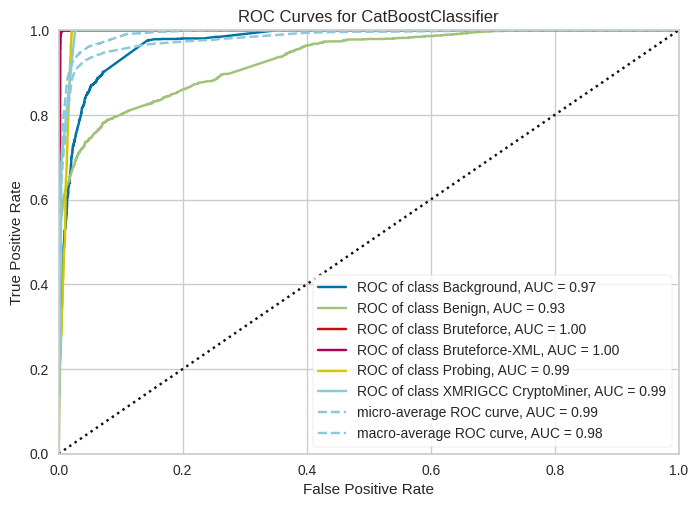

<Axes: title={'center': 'ROC Curves for CatBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [72]:
model = wrap(cat)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

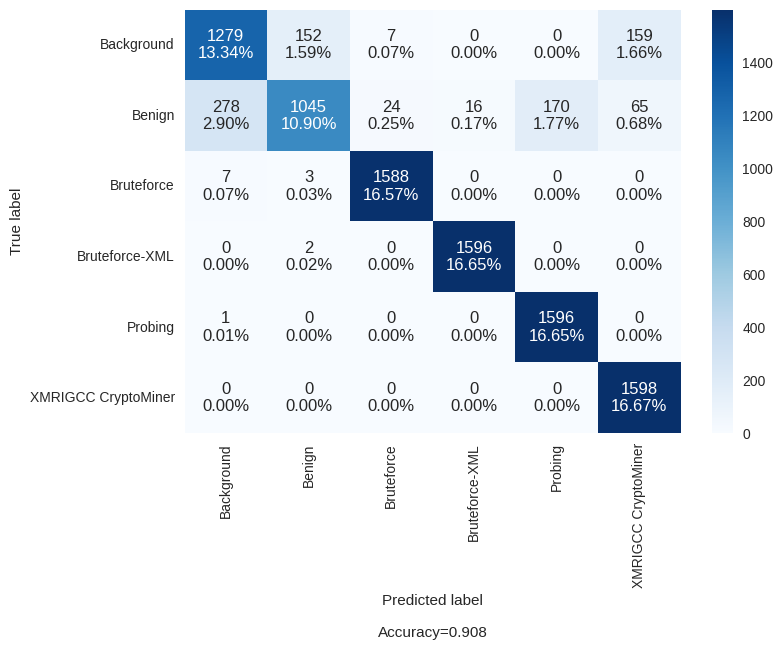

In [73]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(cat.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

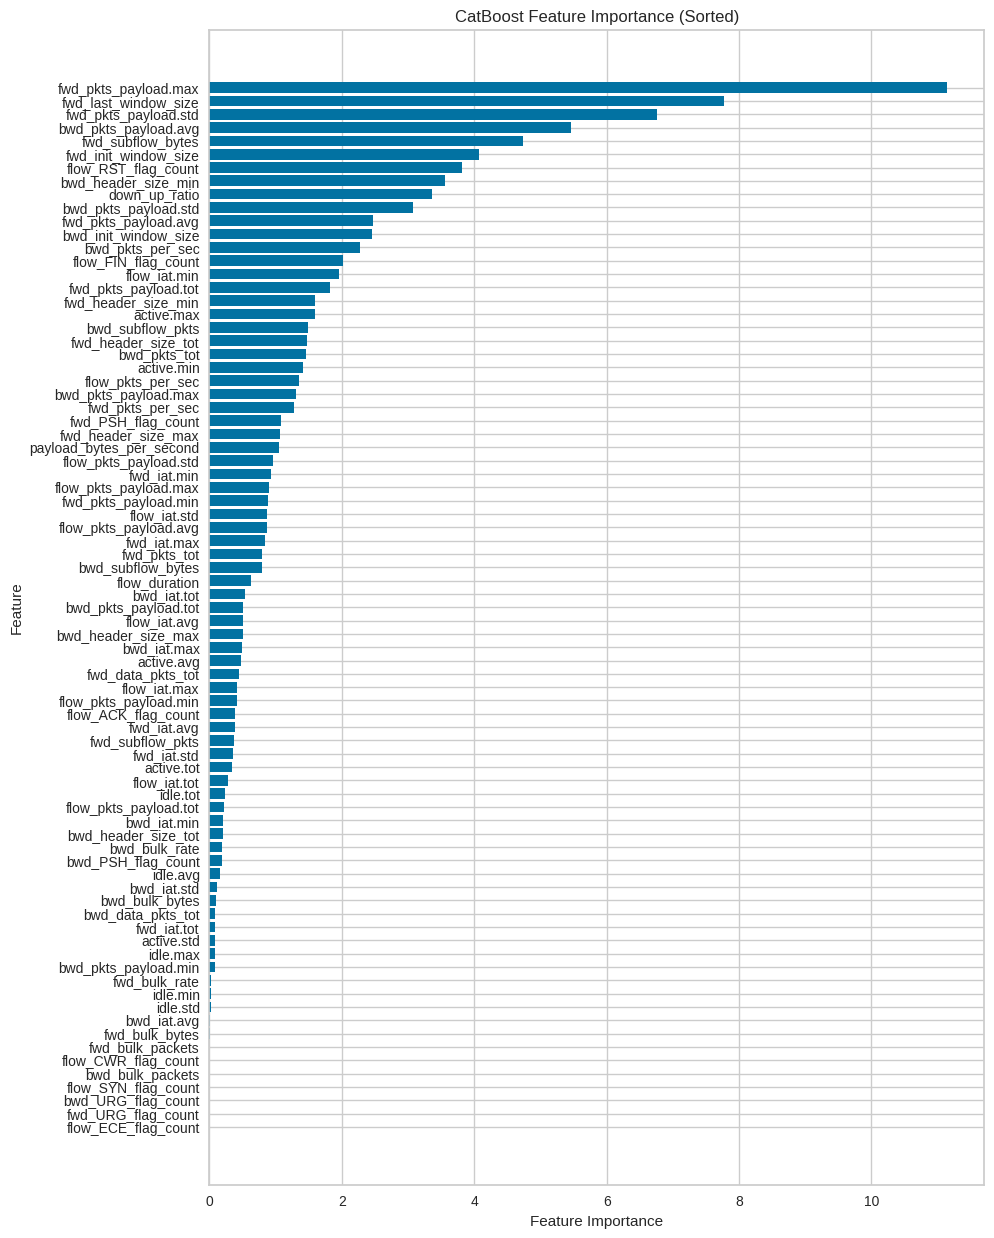

In [74]:
# Retrieve feature importance
feature_importance = model.get_feature_importance(type="FeatureImportance")
feature_names = X_train.columns

# Sort the features and feature importance scores
sorted_indices = np.argsort(feature_importance)
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Sorted)')
plt.show()

Using interventional to stay "true to the model" since we will use this data to do feature reduction and we want also to understand how things work

In [78]:
%%time

explainer = fasttreeshap.TreeExplainer(cat, algorithm='auto', n_jobs=-1) 
sv = explainer(X_train)

CPU times: user 15 s, sys: 444 ms, total: 15.5 s
Wall time: 6.08 s


In [79]:
cat.classes_

array(['Background', 'Benign', 'Bruteforce', 'Bruteforce-XML', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

## Background shap

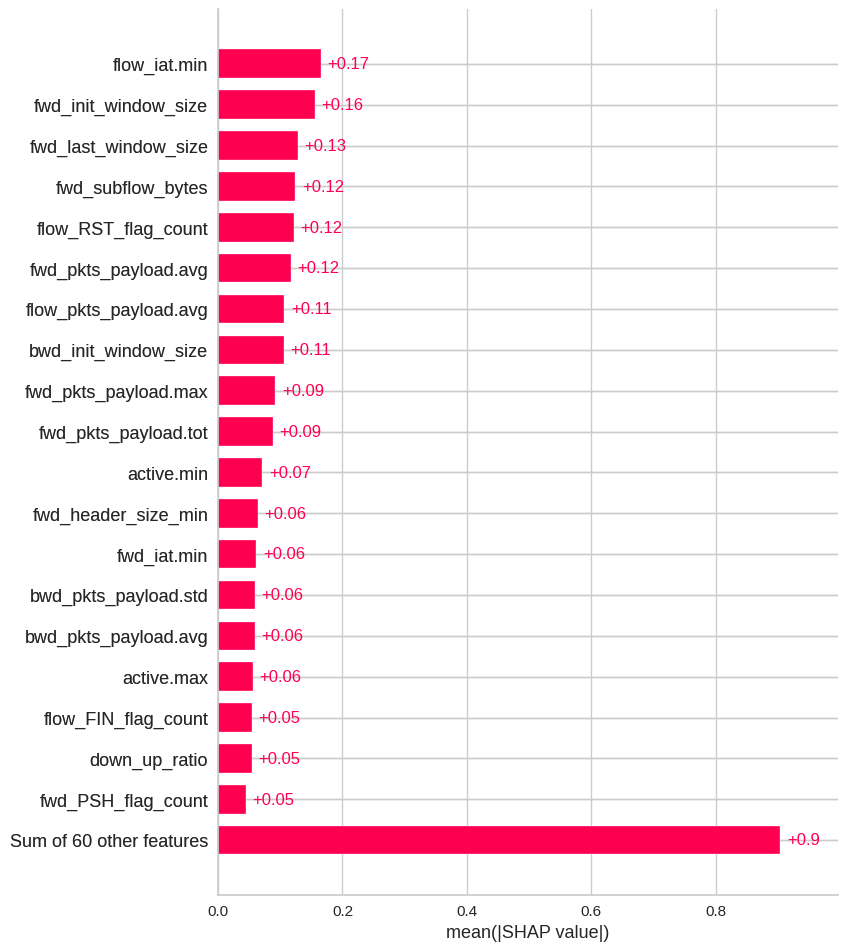

In [80]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

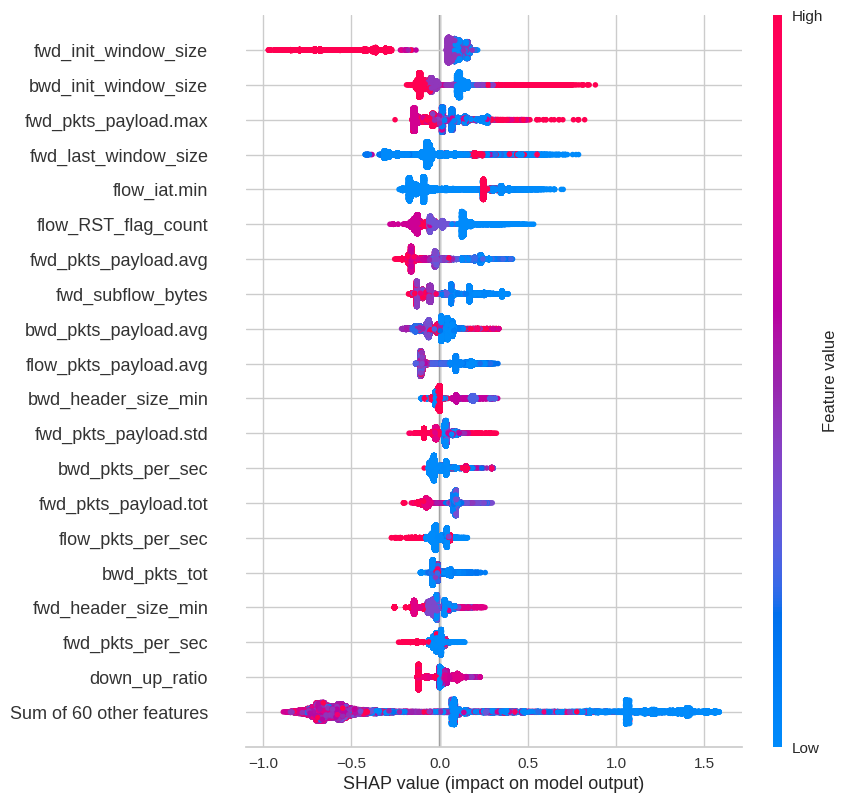

In [81]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

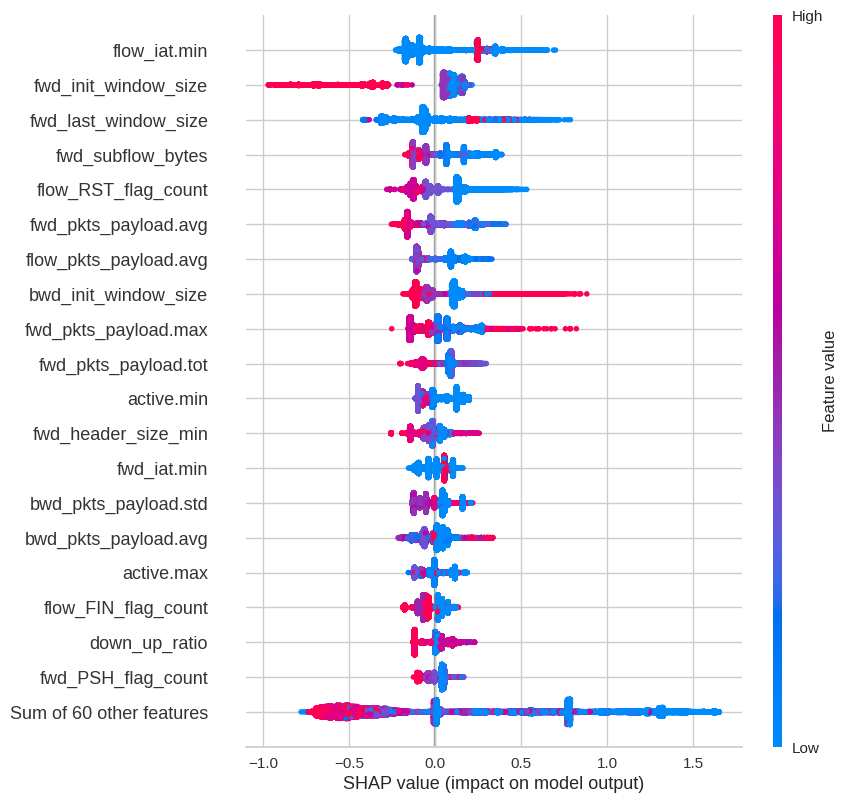

In [82]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bening shap

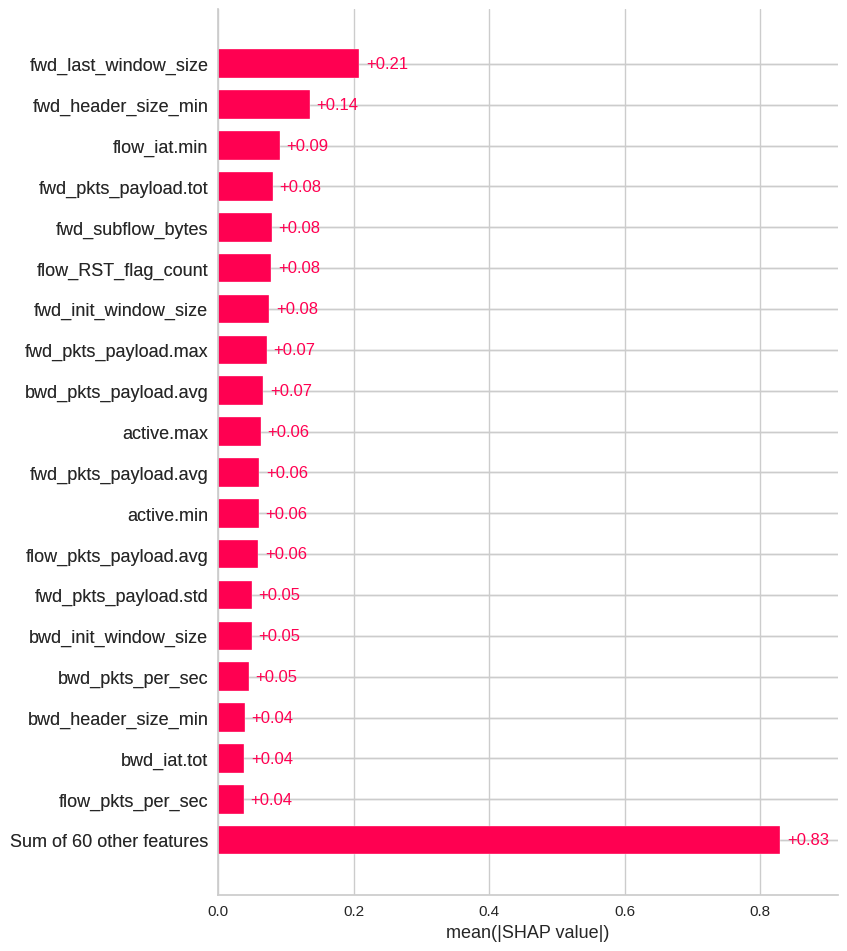

In [83]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

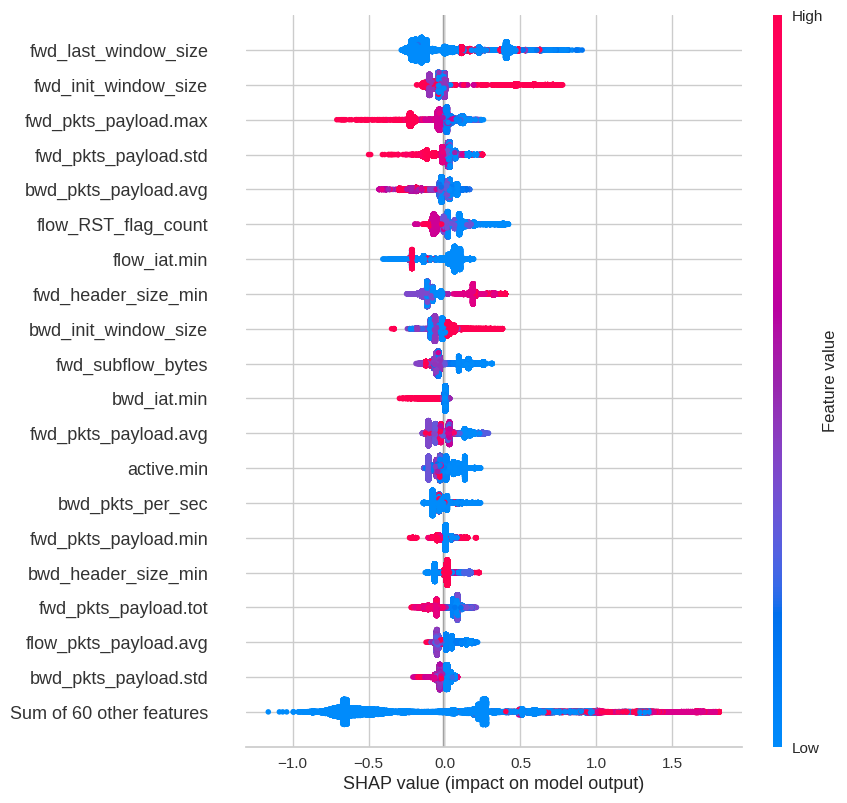

In [84]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

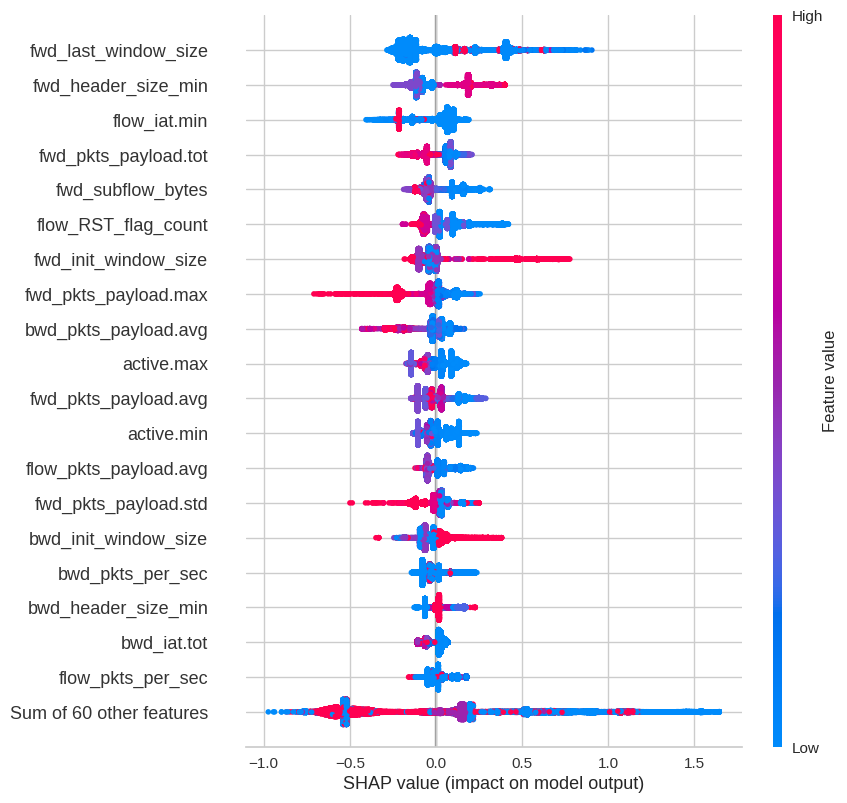

In [85]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

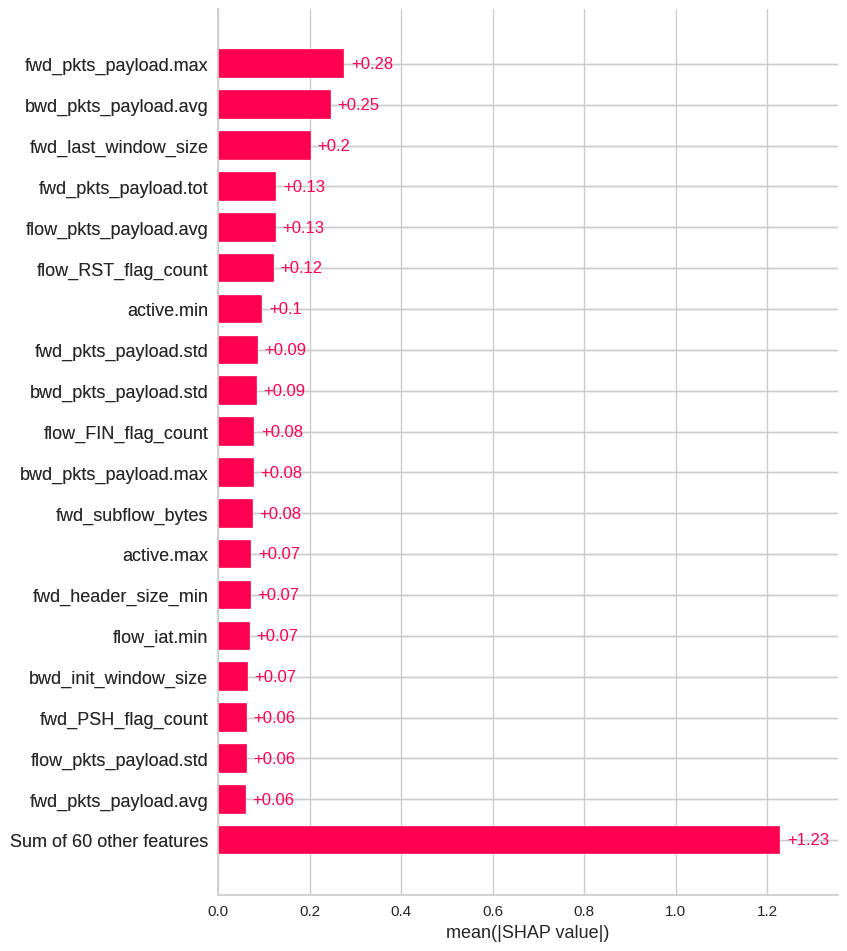

In [86]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

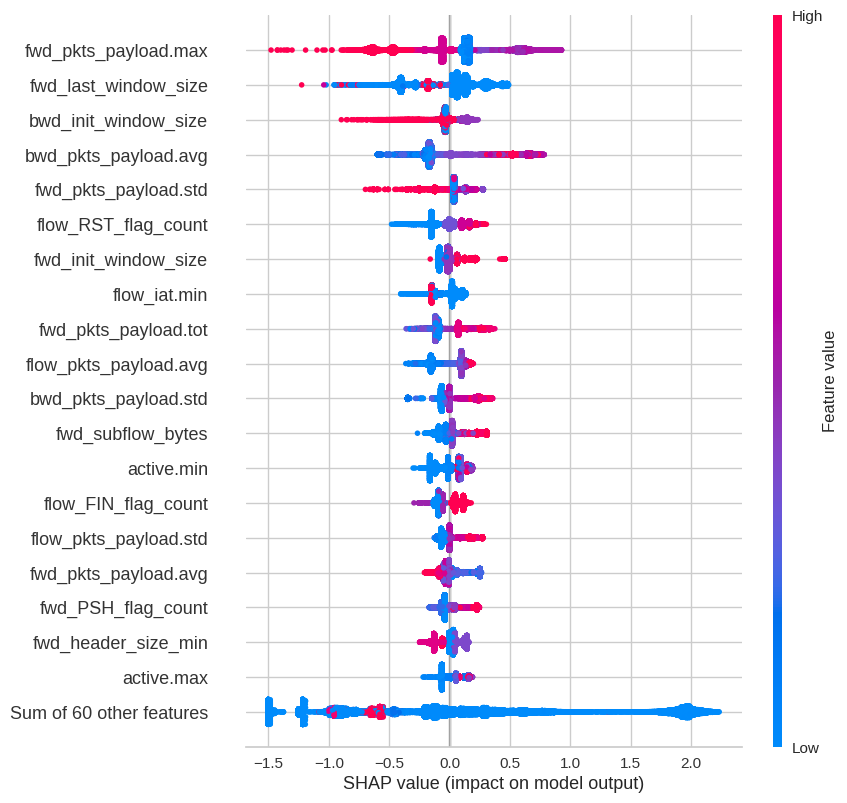

In [87]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

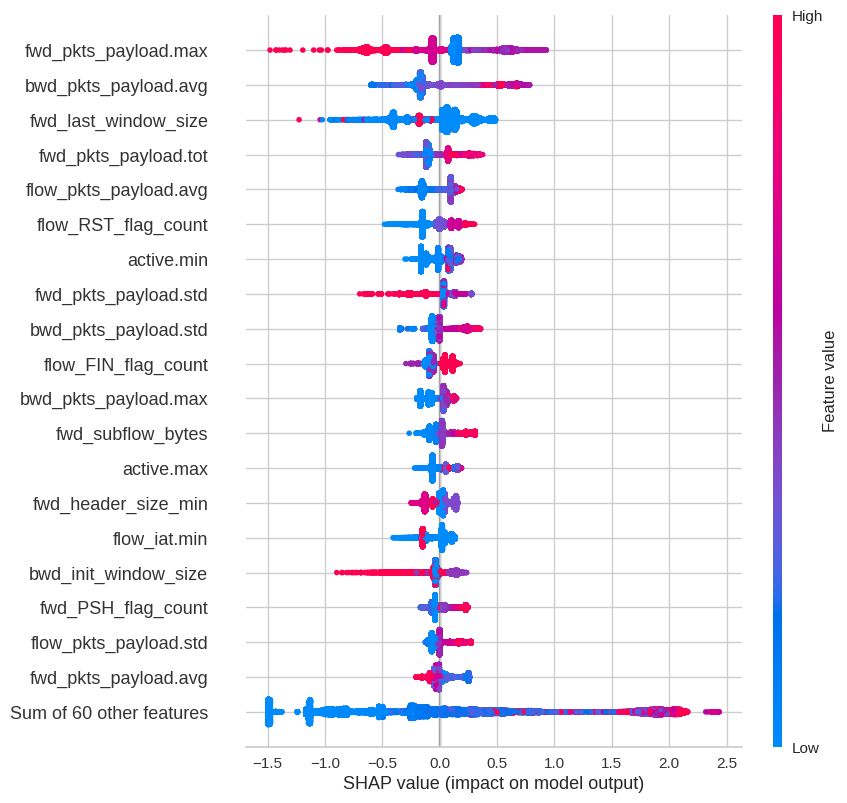

In [88]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

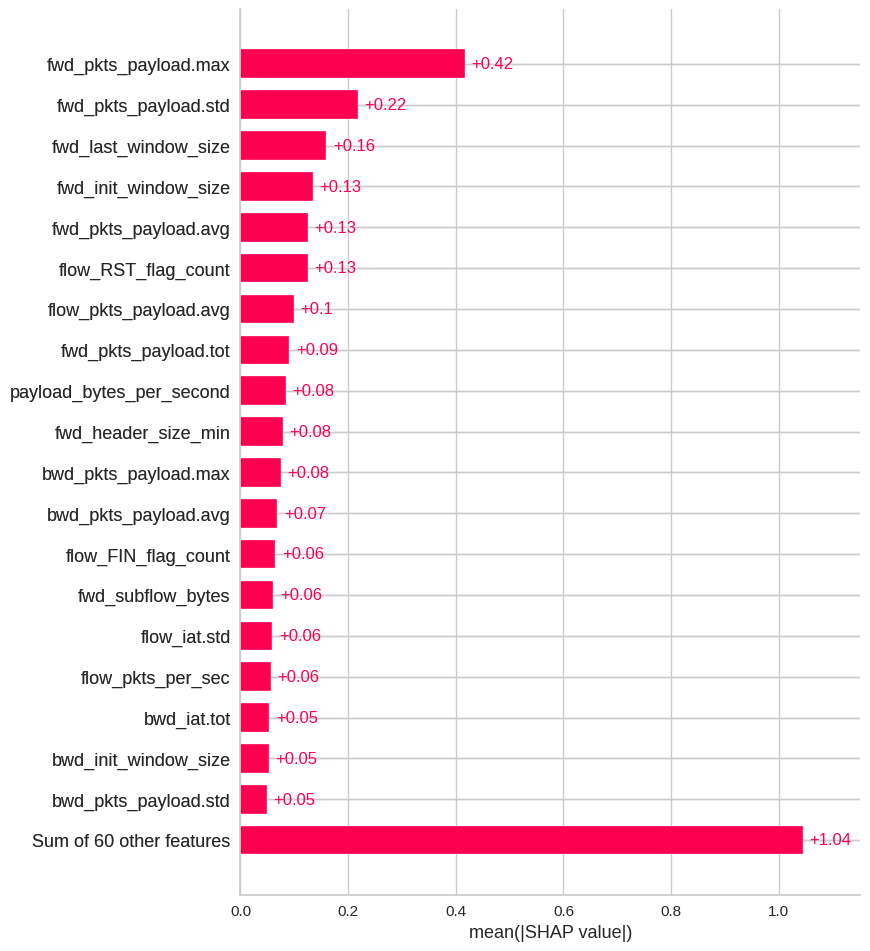

In [89]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

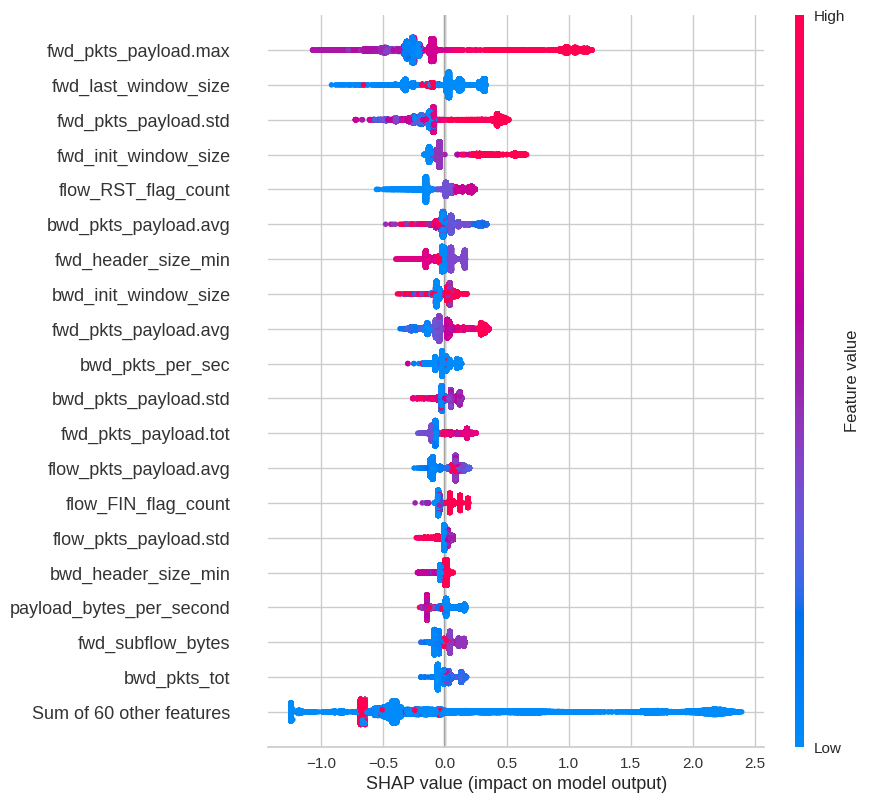

In [90]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

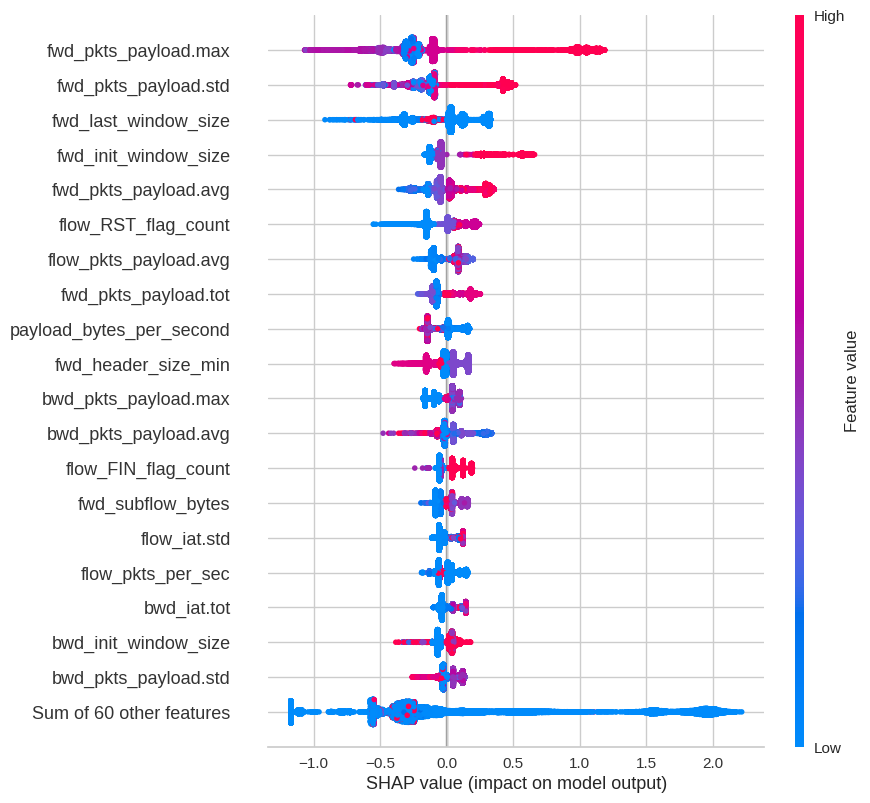

In [91]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

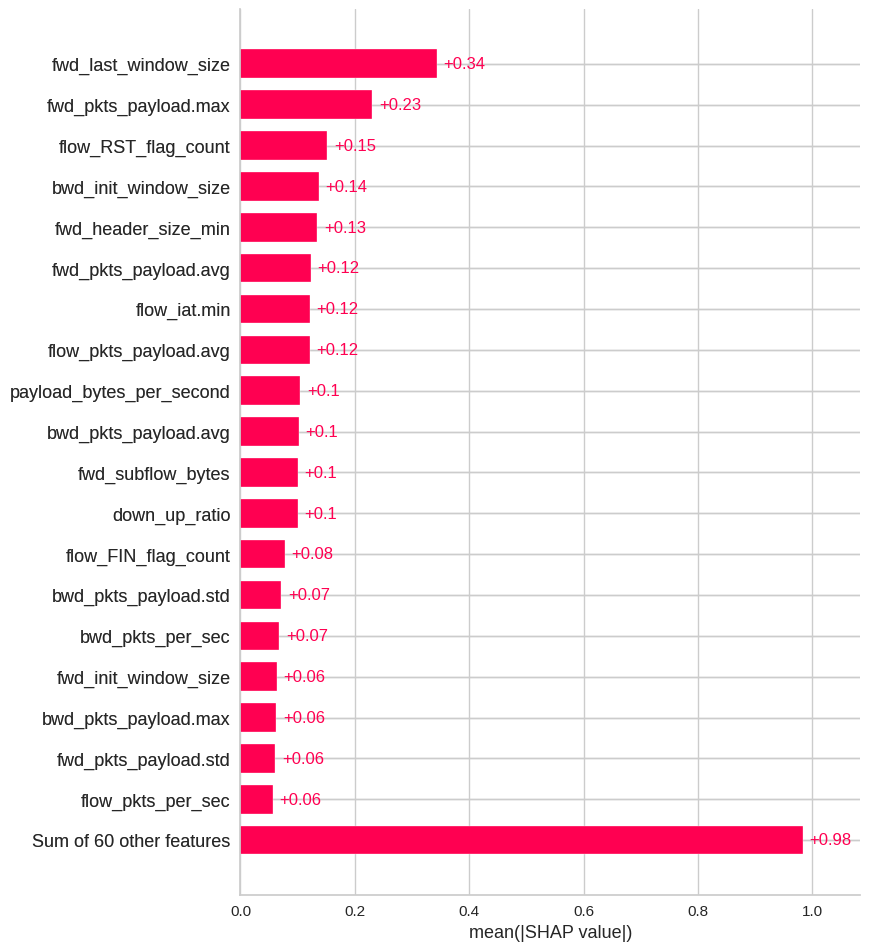

In [92]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

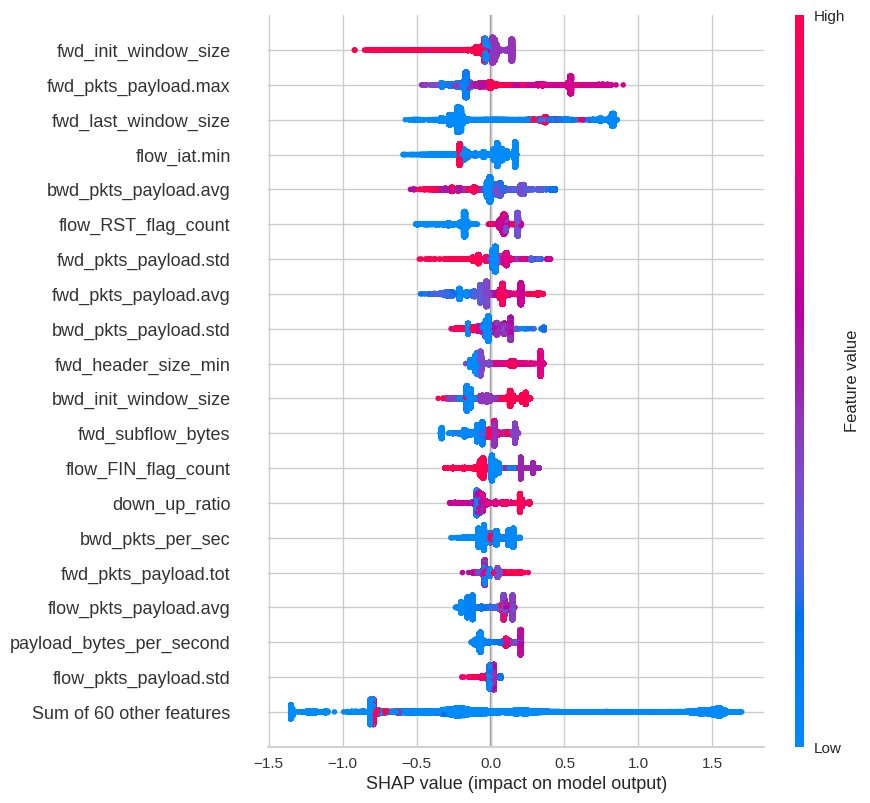

In [93]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

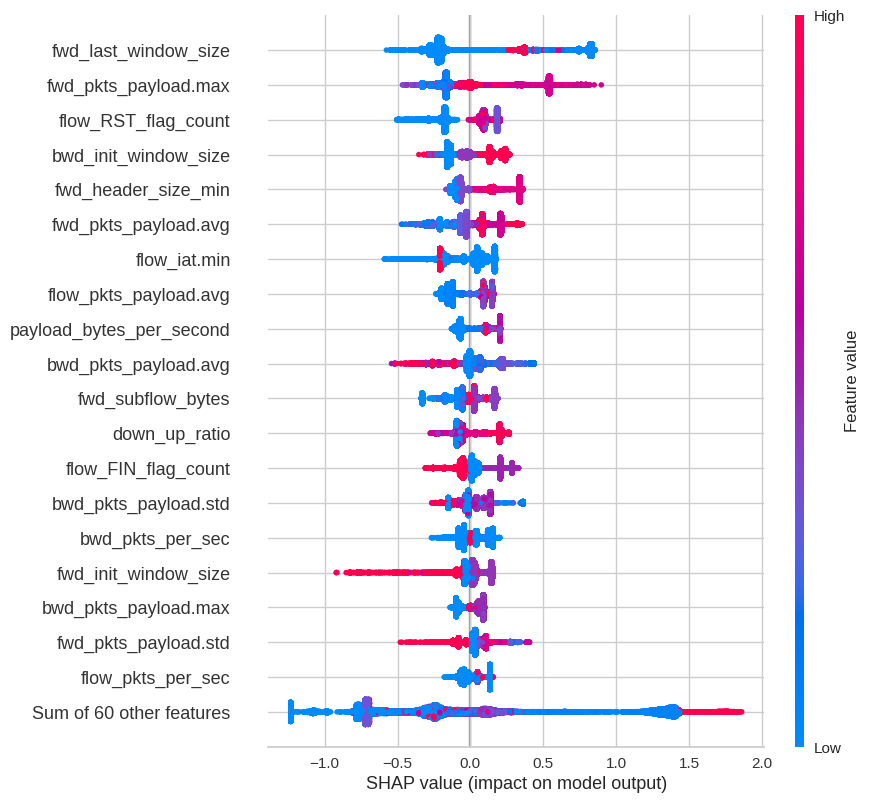

In [94]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

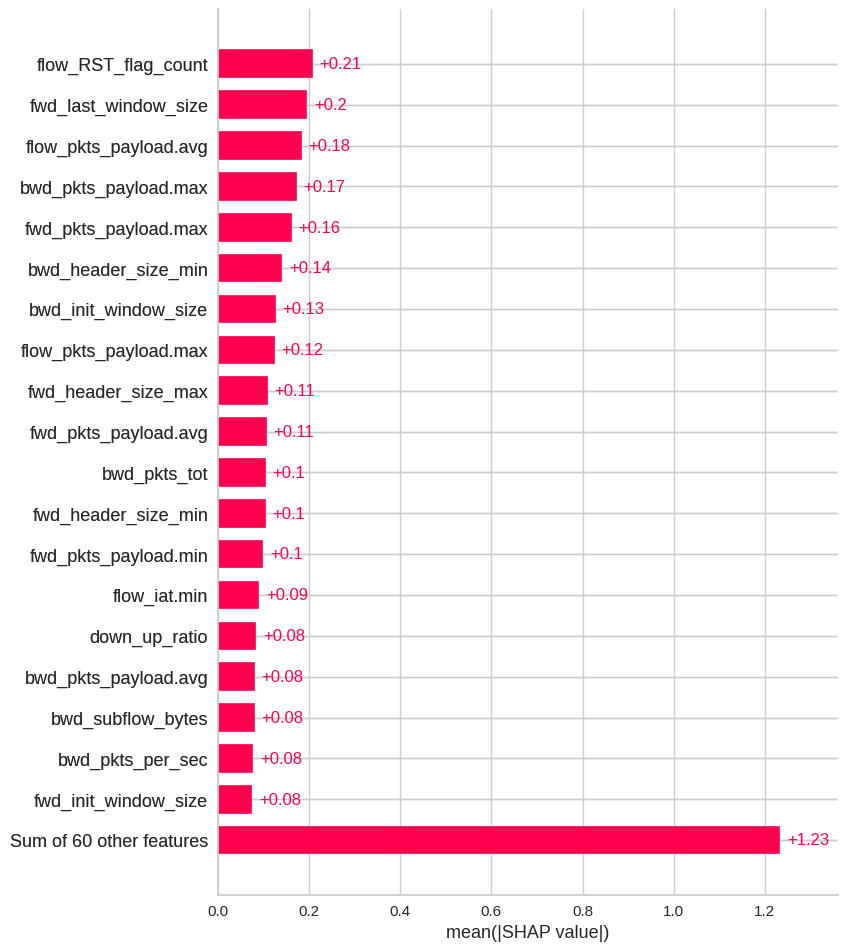

In [95]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)

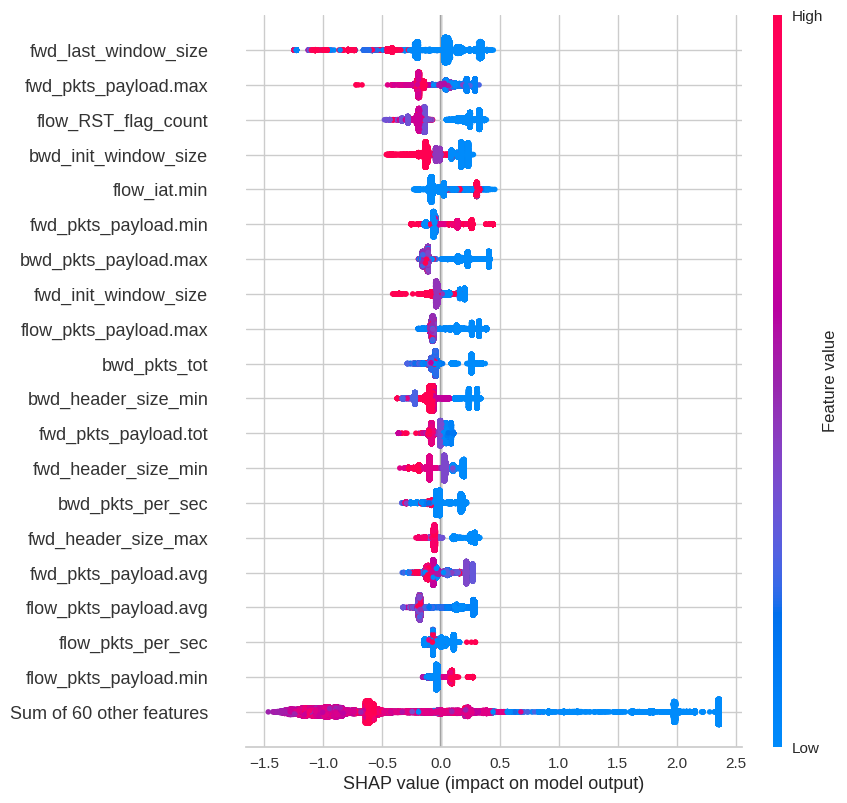

In [96]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

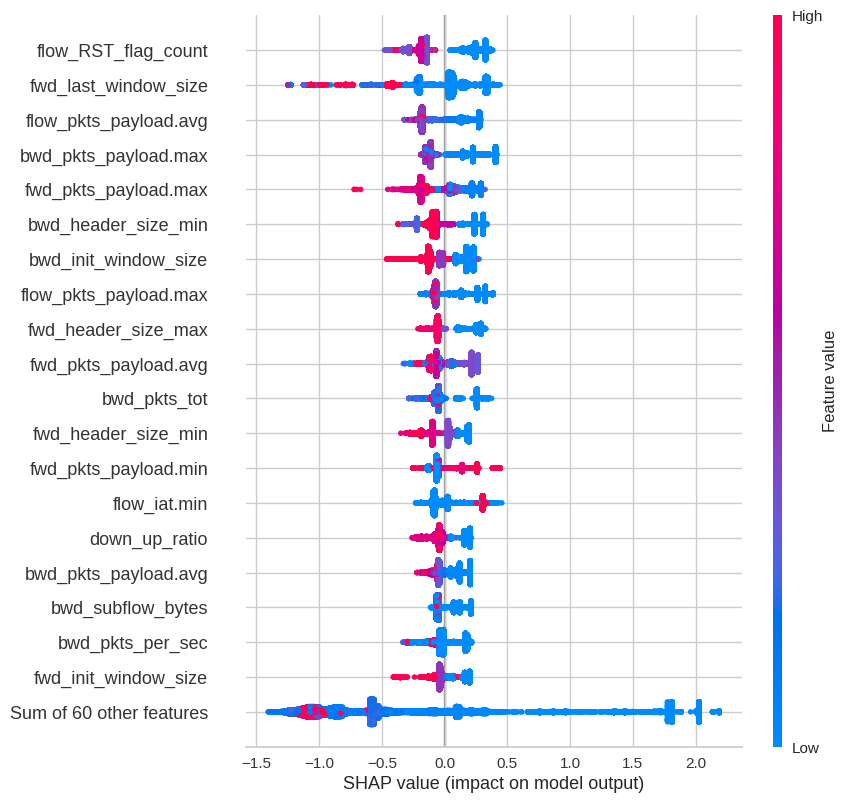

In [97]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Overall importance

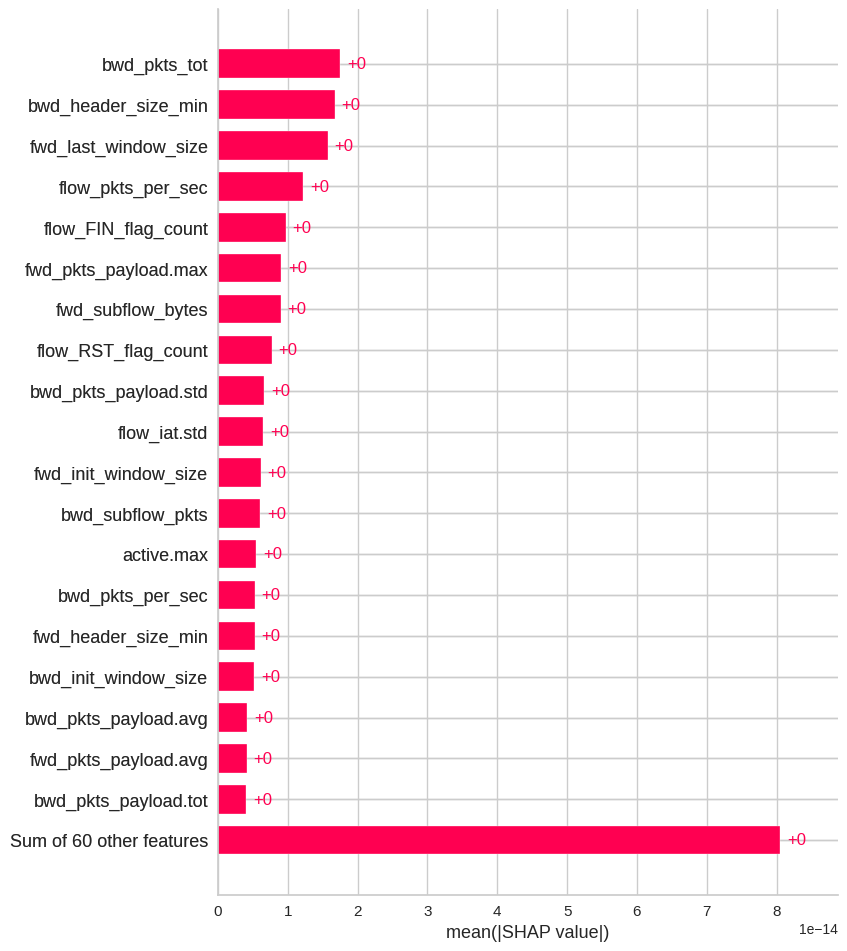

In [98]:
exp = Explanation(sv.values.mean(2), 
                  sv.base_values.mean(1), 
                  data=X_train, 
                  feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

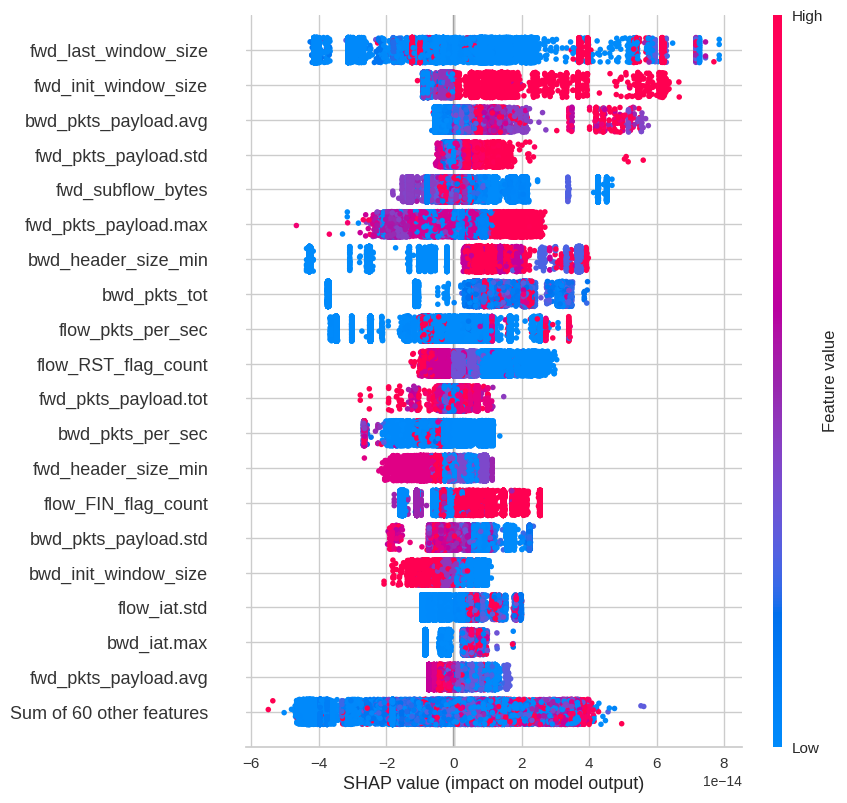

In [99]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

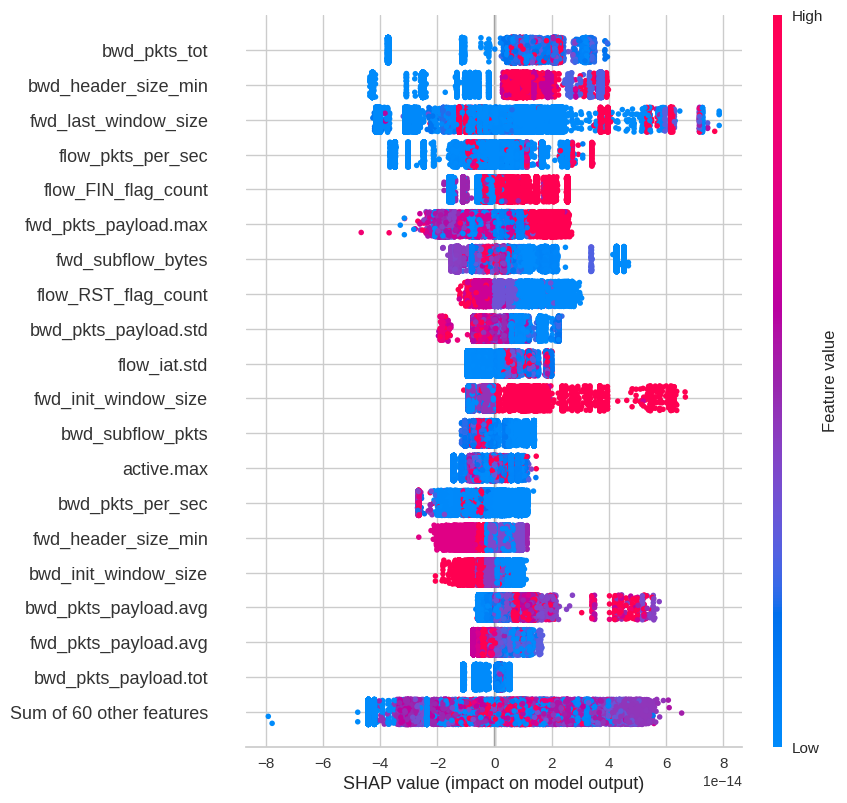

In [100]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [101]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [102]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.3603508	total: 52.6ms	remaining: 4.15s
1:	learn: 1.1963659	total: 109ms	remaining: 4.26s
2:	learn: 1.0684183	total: 169ms	remaining: 4.34s
3:	learn: 0.9690358	total: 232ms	remaining: 4.41s
4:	learn: 0.8855634	total: 298ms	remaining: 4.47s
5:	learn: 0.8181766	total: 368ms	remaining: 4.54s
6:	learn: 0.7619367	total: 439ms	remaining: 4.57s
7:	learn: 0.7151842	total: 514ms	remaining: 4.62s
8:	learn: 0.6734492	total: 596ms	remaining: 4.7s
9:	learn: 0.6358477	total: 678ms	remaining: 4.74s
10:	learn: 0.6036927	total: 769ms	remaining: 4.82s
11:	learn: 0.5769074	total: 857ms	remaining: 4.86s
12:	learn: 0.5514976	total: 947ms	remaining: 4.88s
13:	learn: 0.5287728	total: 1.05s	remaining: 4.95s
14:	learn: 0.5105985	total: 1.15s	remaining: 5s
15:	learn: 0.4919426	total: 1.25s	remaining: 5.01s
16:	learn: 0.4757865	total: 1.35s	remaining: 5.02s
17:	learn: 0.4614312	total: 1.46s	remaining: 5.01s
18:	learn: 0.4479418	total: 1.54s	remaining: 4.96s
19:	learn: 0.4355589	total: 1.63s	remaining:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.896157  0.746505
1  PRECISION  0.896190  0.656197
2     RECALL  0.896157  0.746505
3   F1 SCORE  0.891552  0.694136

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


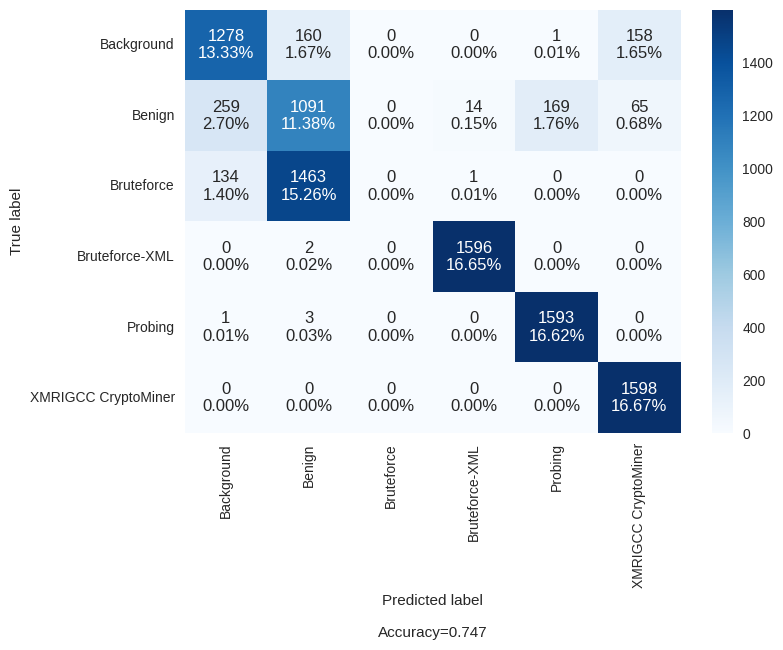

In [103]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [104]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce-XML']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.3590598	total: 61.1ms	remaining: 4.83s
1:	learn: 1.1902869	total: 126ms	remaining: 4.9s
2:	learn: 1.0647211	total: 191ms	remaining: 4.91s
3:	learn: 0.9667146	total: 261ms	remaining: 4.96s
4:	learn: 0.8892329	total: 331ms	remaining: 4.97s
5:	learn: 0.8232032	total: 407ms	remaining: 5.02s
6:	learn: 0.7680471	total: 486ms	remaining: 5.07s
7:	learn: 0.7219021	total: 571ms	remaining: 5.14s
8:	learn: 0.6804894	total: 662ms	remaining: 5.22s
9:	learn: 0.6444321	total: 750ms	remaining: 5.25s
10:	learn: 0.6116477	total: 838ms	remaining: 5.26s
11:	learn: 0.5831328	total: 926ms	remaining: 5.25s
12:	learn: 0.5588990	total: 1.02s	remaining: 5.28s
13:	learn: 0.5373388	total: 1.12s	remaining: 5.29s
14:	learn: 0.5178477	total: 1.22s	remaining: 5.29s
15:	learn: 0.5016329	total: 1.32s	remaining: 5.28s
16:	learn: 0.4848651	total: 1.42s	remaining: 5.27s
17:	learn: 0.4696885	total: 1.52s	remaining: 5.25s
18:	learn: 0.4568032	total: 1.63s	remaining: 5.24s
19:	learn: 0.4455053	total: 1.73s	remaini

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.893496  0.744732
1  PRECISION  0.893225  0.636726
2     RECALL  0.893496  0.744732
3   F1 SCORE  0.888711  0.683731

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


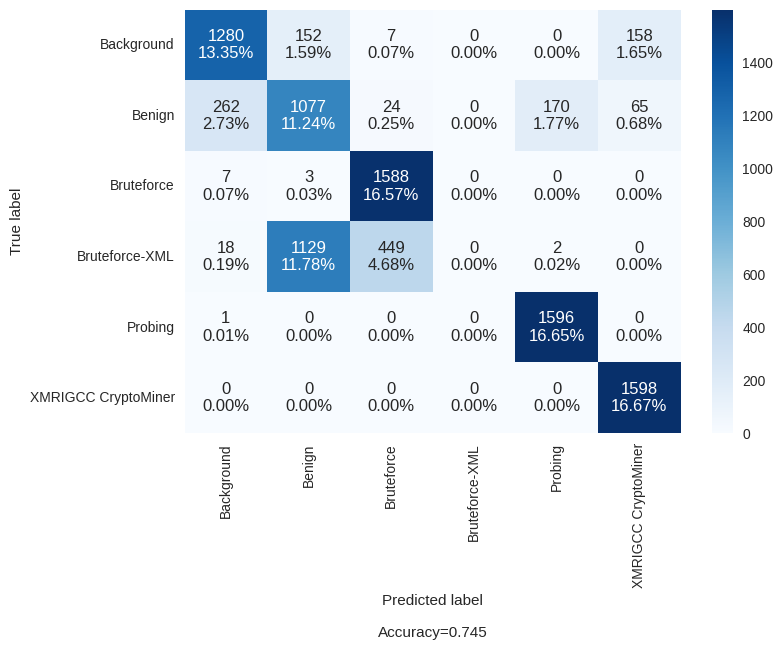

In [105]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [106]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Probing']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.3441631	total: 68.8ms	remaining: 5.43s
1:	learn: 1.1690821	total: 140ms	remaining: 5.48s
2:	learn: 1.0388620	total: 213ms	remaining: 5.46s
3:	learn: 0.9366008	total: 290ms	remaining: 5.51s
4:	learn: 0.8512010	total: 373ms	remaining: 5.59s
5:	learn: 0.7824875	total: 460ms	remaining: 5.67s
6:	learn: 0.7250821	total: 555ms	remaining: 5.79s
7:	learn: 0.6754413	total: 666ms	remaining: 6s
8:	learn: 0.6313423	total: 767ms	remaining: 6.05s
9:	learn: 0.5926512	total: 871ms	remaining: 6.1s
10:	learn: 0.5596286	total: 974ms	remaining: 6.11s
11:	learn: 0.5327001	total: 1.08s	remaining: 6.11s
12:	learn: 0.5070043	total: 1.18s	remaining: 6.09s
13:	learn: 0.4844624	total: 1.29s	remaining: 6.07s
14:	learn: 0.4641348	total: 1.39s	remaining: 6.02s
15:	learn: 0.4470230	total: 1.49s	remaining: 5.97s
16:	learn: 0.4306613	total: 1.6s	remaining: 5.93s
17:	learn: 0.4158161	total: 1.7s	remaining: 5.87s
18:	learn: 0.4023513	total: 1.81s	remaining: 5.8s
19:	learn: 0.3905398	total: 1.92s	remaining: 5.

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.911928  0.759962
1  PRECISION  0.912204  0.679032
2     RECALL  0.911928  0.759962
3   F1 SCORE  0.909837  0.710133

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


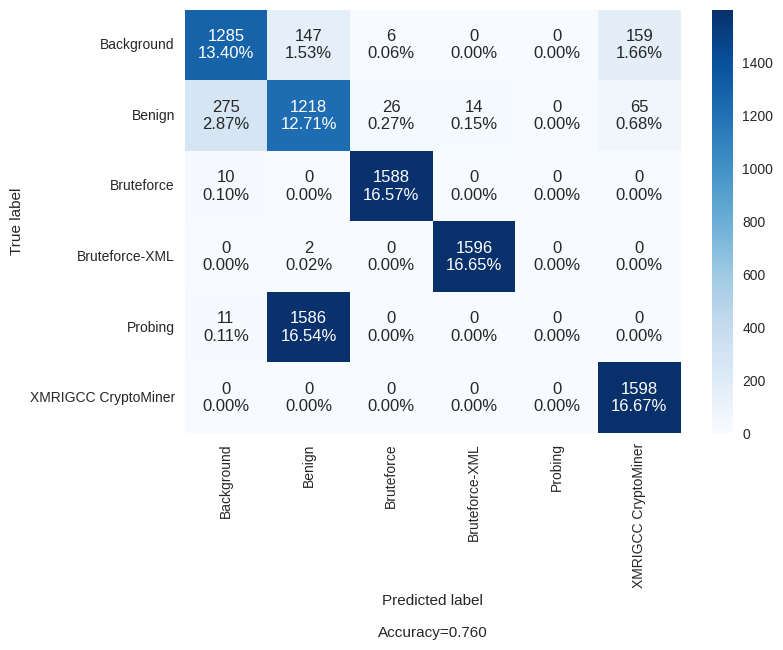

In [107]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [108]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'XMRIGCC CryptoMiner']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
cat.fit(X_train_attack, y_train_attack)
y_predicted_train = cat.predict(X_train_attack)
y_predicted_test = cat.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

0:	learn: 1.3361090	total: 113ms	remaining: 8.91s
1:	learn: 1.1600413	total: 216ms	remaining: 8.43s
2:	learn: 1.0277380	total: 329ms	remaining: 8.44s
3:	learn: 0.9229203	total: 433ms	remaining: 8.23s
4:	learn: 0.8390860	total: 535ms	remaining: 8.02s
5:	learn: 0.7694026	total: 640ms	remaining: 7.9s
6:	learn: 0.7112566	total: 743ms	remaining: 7.75s
7:	learn: 0.6631412	total: 846ms	remaining: 7.61s
8:	learn: 0.6202682	total: 949ms	remaining: 7.49s
9:	learn: 0.5831311	total: 1.05s	remaining: 7.37s
10:	learn: 0.5508298	total: 1.16s	remaining: 7.26s
11:	learn: 0.5222448	total: 1.26s	remaining: 7.17s
12:	learn: 0.4974353	total: 1.38s	remaining: 7.09s
13:	learn: 0.4749648	total: 1.48s	remaining: 6.99s
14:	learn: 0.4552149	total: 1.59s	remaining: 6.89s
15:	learn: 0.4381254	total: 1.7s	remaining: 6.79s
16:	learn: 0.4201015	total: 1.8s	remaining: 6.66s
17:	learn: 0.4057451	total: 1.9s	remaining: 6.55s
18:	learn: 0.3925106	total: 2.01s	remaining: 6.45s
19:	learn: 0.3805679	total: 2.11s	remaining: 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.912932  0.758606
1  PRECISION  0.914798  0.693814
2     RECALL  0.912932  0.758606
3   F1 SCORE  0.908748  0.709427

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


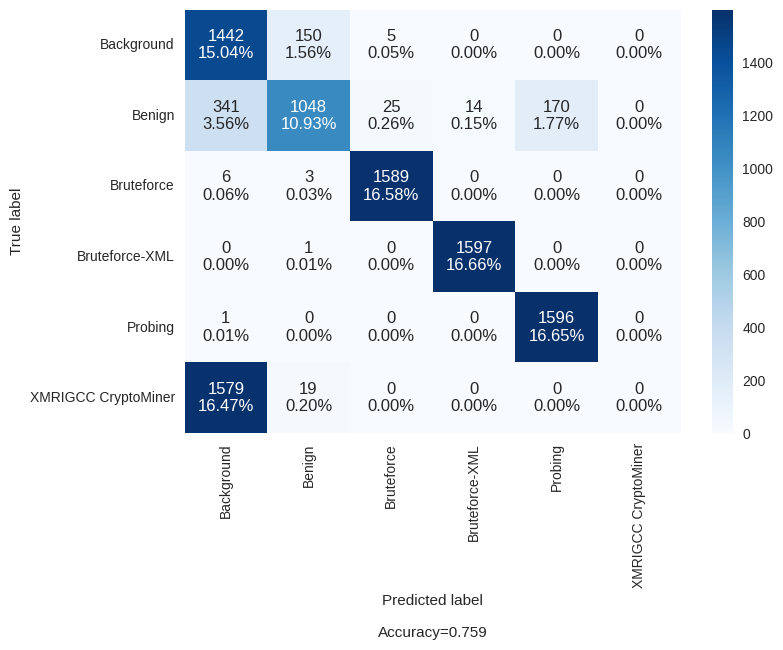

In [109]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')